Using device: cuda

Loading processed data...
Total samples: 112677
Falls: 17980
Non-Falls: 94697

Splitting data into Train/Val/Test...
Train: 90141 samples
Val:   11268 samples
Test:  11268 samples

PHASE 1: CONTRASTIVE LEARNING (Self-Supervised)
Epochs: 50, LR: 0.0003, Scheduler: ReduceLROnPlateau


Epoch 5/50: 100%|██████████| 705/705 [01:37<00:00,  7.20it/s, loss=2.4688]


  Epoch 5/50 - Loss: 3.8684 - LR: 0.000300 - Patience: 0/10


Epoch 10/50: 100%|██████████| 705/705 [01:31<00:00,  7.73it/s, loss=2.5342]


  Epoch 10/50 - Loss: 3.8313 - LR: 0.000300 - Patience: 0/10


Epoch 15/50: 100%|██████████| 705/705 [01:30<00:00,  7.78it/s, loss=2.3662]


  Epoch 15/50 - Loss: 3.8122 - LR: 0.000300 - Patience: 0/10


Epoch 20/50: 100%|██████████| 705/705 [01:32<00:00,  7.65it/s, loss=2.4380]


  Epoch 20/50 - Loss: 3.8007 - LR: 0.000300 - Patience: 0/10


Epoch 25/50: 100%|██████████| 705/705 [01:31<00:00,  7.74it/s, loss=2.3552]


  Epoch 25/50 - Loss: 3.7935 - LR: 0.000300 - Patience: 0/10


Epoch 30/50: 100%|██████████| 705/705 [01:31<00:00,  7.70it/s, loss=2.3606]


  Epoch 30/50 - Loss: 3.7862 - LR: 0.000300 - Patience: 0/10


Epoch 35/50: 100%|██████████| 705/705 [01:31<00:00,  7.70it/s, loss=2.3916]


  Epoch 35/50 - Loss: 3.7817 - LR: 0.000300 - Patience: 1/10


Epoch 40/50: 100%|██████████| 705/705 [01:30<00:00,  7.76it/s, loss=2.3669]


  Epoch 40/50 - Loss: 3.7771 - LR: 0.000300 - Patience: 1/10


Epoch 45/50: 100%|██████████| 705/705 [01:30<00:00,  7.77it/s, loss=2.4499]


  Epoch 45/50 - Loss: 3.7727 - LR: 0.000300 - Patience: 0/10


Epoch 50/50: 100%|██████████| 705/705 [01:31<00:00,  7.73it/s, loss=2.2816]


  Epoch 50/50 - Loss: 3.7690 - LR: 0.000300 - Patience: 0/10

✅ Best encoder saved to: /home/ashutosh/Desktop/hackathon training/protobytes-2.0-team-Coder-Rex/models/encoder.pth

PHASE 2: FALL DETECTION (Supervised)
Epochs: 50, LR: 0.001, Scheduler: ReduceLROnPlateau
  Epoch 5/50 - Loss: 0.0904 - Val Acc: 96.66% - Best: 96.66% - Patience: 0/10
  Epoch 10/50 - Loss: 0.0785 - Val Acc: 97.09% - Best: 97.35% - Patience: 1/10
  Epoch 15/50 - Loss: 0.0716 - Val Acc: 97.49% - Best: 97.49% - Patience: 0/10
  Epoch 20/50 - Loss: 0.0671 - Val Acc: 97.29% - Best: 97.62% - Patience: 2/10
  Epoch 25/50 - Loss: 0.0648 - Val Acc: 97.75% - Best: 97.84% - Patience: 1/10
  Epoch 30/50 - Loss: 0.0624 - Val Acc: 97.91% - Best: 97.92% - Patience: 2/10
  Epoch 35/50 - Loss: 0.0571 - Val Acc: 98.00% - Best: 98.00% - Patience: 0/10
  Epoch 40/50 - Loss: 0.0551 - Val Acc: 98.15% - Best: 98.15% - Patience: 0/10
  Epoch 45/50 - Loss: 0.0534 - Val Acc: 98.09% - Best: 98.15% - Patience: 5/10
  Epoch 50/50 - Loss: 

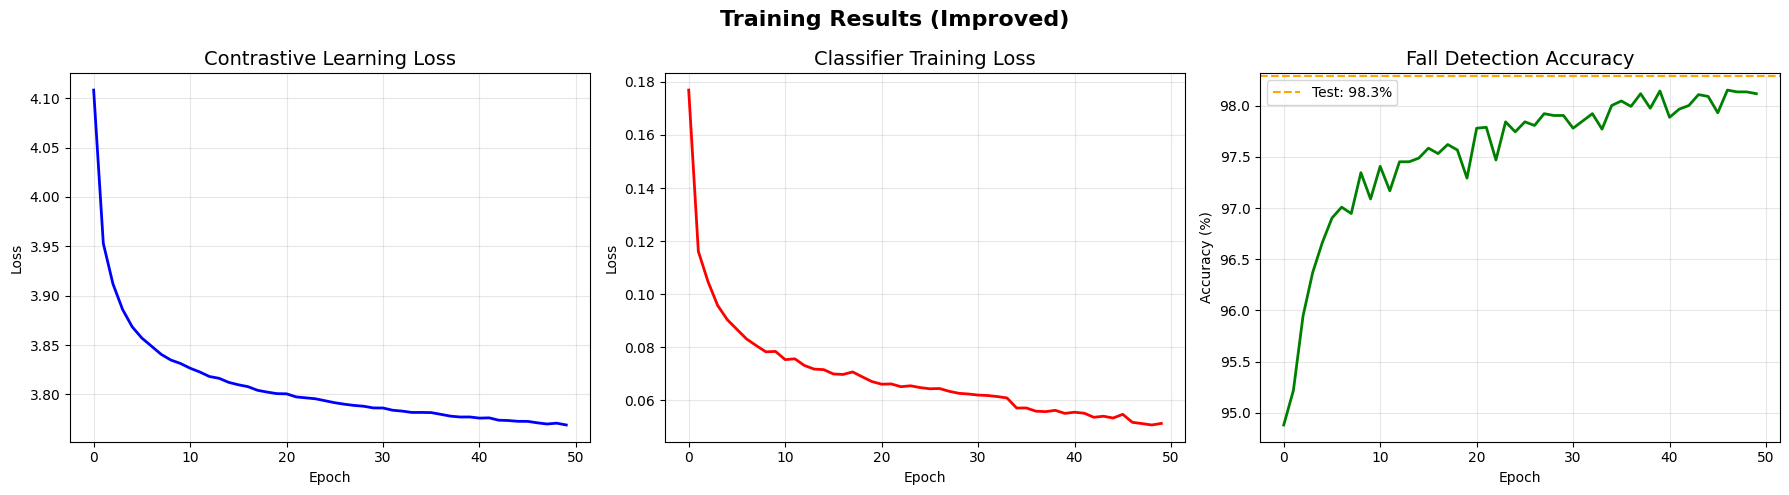

In [4]:
"""
Training script for the complete pipeline:
1. Train encoder with contrastive learning (self-supervised)
2. Train fall detection classifier (supervised)
"""

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import pickle
import os
import sys
sys.path.append(os.path.abspath('../src'))  # Add src folder to path
sys.path.append(os.path.abspath('src')) 
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from model import IMUEncoder, ContrastiveLoss, FallDetectionClassifier
from dataset import ContrastiveIMUDataset, IMUDataset


def train_contrastive(model, dataloader, criterion, optimizer, device, epochs=50):
    """
    Phase 1: Train encoder using contrastive learning

    The model learns to create similar embeddings for similar motions
    WITHOUT using any labels (self-supervised)
    """

    model.train()
    all_losses = []

    print("\n" + "=" * 60)
    print("PHASE 1: CONTRASTIVE LEARNING (Self-Supervised)")
    print("No labels used! The model teaches itself.")
    print("=" * 60)

    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0

        progress = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for view1, view2, labels, sources in progress:
            view1 = view1.to(device)
            view2 = view2.to(device)

            # Forward: get embeddings for both views
            z1 = model(view1)
            z2 = model(view2)

            # Compute contrastive loss
            loss = criterion(z1, z2)

            # Backward: update model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

            progress.set_postfix({"loss": f"{loss.item():.4f}"})

        avg_loss = epoch_loss / num_batches
        all_losses.append(avg_loss)

        # Print every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}/{epochs} - Avg Loss: {avg_loss:.4f}")

    return all_losses


def train_fall_classifier(
    encoder,
    classifier,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=30,
):
    """
    Phase 2: Train fall detection classifier

    The encoder is FROZEN (not updated)
    Only the classifier learns to detect falls from embeddings
    """

    encoder.eval()  # Freeze encoder

    all_train_losses = []
    all_val_accuracies = []
    best_accuracy = 0

    print("\n" + "=" * 60)
    print("PHASE 2: FALL DETECTION (Supervised)")
    print("Encoder is frozen. Only classifier is learning.")
    print("=" * 60)

    label_map = {"Fall": 1, "Non-Fall": 0}

    for epoch in range(epochs):
        # --- Training ---
        classifier.train()
        epoch_loss = 0.0
        num_batches = 0

        for data, labels, sources in train_loader:
            data = data.to(device)
            label_tensor = torch.tensor([label_map.get(l, 0) for l in labels]).to(
                device
            )

            # Get embeddings from frozen encoder
            with torch.no_grad():
                embeddings = encoder.get_embedding(data)

            # Classify
            outputs = classifier(embeddings)
            loss = criterion(outputs, label_tensor)

            # Update classifier only
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

        avg_loss = epoch_loss / num_batches
        all_train_losses.append(avg_loss)

        # --- Validation ---
        classifier.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for data, labels, sources in val_loader:
                data = data.to(device)
                label_tensor = torch.tensor([label_map.get(l, 0) for l in labels]).to(
                    device
                )

                embeddings = encoder.get_embedding(data)
                outputs = classifier(embeddings)
                predictions = torch.argmax(outputs, dim=1)

                total += label_tensor.size(0)
                correct += (predictions == label_tensor).sum().item()

        accuracy = 100 * correct / total
        all_val_accuracies.append(accuracy)

        if accuracy > best_accuracy:
            best_accuracy = accuracy

        # Print every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(
                f"  Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f} - Val Acc: {accuracy:.2f}% - Best: {best_accuracy:.2f}%"
            )

    return all_train_losses, all_val_accuracies


def main():
    """Improved training pipeline with all fixes"""
    
    start_time = time.time()
    
    # ============================================
    # SETUP
    # ============================================
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Paths
    base_path = r"/home/ashutosh/Desktop/hackathon training/protobytes-2.0-team-Coder-Rex"
    data_path = os.path.join(base_path, "data", "processed", "combined_dataset.pkl")
    models_path = os.path.join(base_path, "models")
    docs_path = os.path.join(base_path, "docs")
    
    os.makedirs(models_path, exist_ok=True)
    os.makedirs(docs_path, exist_ok=True)
    
    # ============================================
    # LOAD DATA
    # ============================================
    
    print("\nLoading processed data...")
    with open(data_path, 'rb') as f:
        dataset = pickle.load(f)
    
    X = dataset['data']
    y = dataset['binary_labels']
    sources = dataset['sources']
    
    print(f"Total samples: {len(X)}")
    print(f"Falls: {np.sum(y == 'Fall')}")
    print(f"Non-Falls: {np.sum(y == 'Non-Fall')}")
    
    # ============================================
    # SPLIT DATA (Train / Validation / Test)
    # ============================================
    
    print("\nSplitting data into Train/Val/Test...")
    
    # First split: 80% train, 20% temp
    X_train, X_temp, y_train, y_temp, src_train, src_temp = train_test_split(
        X, y, sources, test_size=0.2, random_state=42, stratify=y
    )
    
    # Second split: 50% val, 50% test (from temp)
    X_val, X_test, y_val, y_test, src_val, src_test = train_test_split(
        X_temp, y_temp, src_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    print(f"Train: {len(X_train)} samples")
    print(f"Val:   {len(X_val)} samples")
    print(f"Test:  {len(X_test)} samples")
    
    # ============================================
    # CREATE DATALOADERS
    # ============================================
    
    contrastive_dataset = ContrastiveIMUDataset(X_train, y_train, src_train)
    contrastive_loader = DataLoader(contrastive_dataset, batch_size=128, shuffle=True, num_workers=0)
    
    train_dataset = IMUDataset(X_train, y_train, src_train)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
    
    val_dataset = IMUDataset(X_val, y_val, src_val)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=0)
    
    test_dataset = IMUDataset(X_test, y_test, src_test)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=0)
    
    # ============================================
    # PHASE 1: CONTRASTIVE LEARNING (IMPROVED)
    # ============================================
    
    encoder = IMUEncoder(input_channels=3, embedding_dim=128).to(device)
    contrastive_criterion = ContrastiveLoss(temperature=0.5)
    
    # FIX 1: Lower learning rate
    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.0003)
    
    # FIX 2: Learning rate scheduler (reduce when loss plateaus)
    encoder_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    encoder_optimizer, mode='min', factor=0.5, patience=5
)
    
    # FIX 3: More epochs for contrastive learning
    contrastive_epochs = 50
    
    print("\n" + "=" * 60)
    print("PHASE 1: CONTRASTIVE LEARNING (Self-Supervised)")
    print(f"Epochs: {contrastive_epochs}, LR: 0.0003, Scheduler: ReduceLROnPlateau")
    print("=" * 60)
    
    encoder.train()
    contrastive_losses = []
    best_contrastive_loss = float('inf')
    patience_counter = 0
    max_patience = 10  # FIX 4: Early stopping
    
    for epoch in range(contrastive_epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        progress = tqdm(contrastive_loader, desc=f"Epoch {epoch+1}/{contrastive_epochs}")
        
        for view1, view2, labels, srcs in progress:
            view1 = view1.to(device)
            view2 = view2.to(device)
            
            z1 = encoder(view1)
            z2 = encoder(view2)
            
            loss = contrastive_criterion(z1, z2)
            
            encoder_optimizer.zero_grad()
            loss.backward()
            encoder_optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
            progress.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_loss = epoch_loss / num_batches
        contrastive_losses.append(avg_loss)
        
        # Update scheduler
        encoder_scheduler.step(avg_loss)
        
        # Early stopping check
        if avg_loss < best_contrastive_loss:
            best_contrastive_loss = avg_loss
            patience_counter = 0
            # Save best encoder
            torch.save(encoder.state_dict(), os.path.join(models_path, "encoder_best.pth"))
        else:
            patience_counter += 1
        
        current_lr = encoder_optimizer.param_groups[0]['lr']
        
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}/{contrastive_epochs} - Loss: {avg_loss:.4f} - LR: {current_lr:.6f} - Patience: {patience_counter}/{max_patience}")
        
        # Early stopping
        if patience_counter >= max_patience:
            print(f"\n  Early stopping at epoch {epoch+1}! No improvement for {max_patience} epochs.")
            break
    
    # Load best encoder
    encoder.load_state_dict(torch.load(os.path.join(models_path, "encoder_best.pth")))
    
    encoder_path = os.path.join(models_path, "encoder.pth")
    torch.save(encoder.state_dict(), encoder_path)
    print(f"\n✅ Best encoder saved to: {encoder_path}")
    
    # ============================================
    # PHASE 2: FALL DETECTION CLASSIFIER (IMPROVED)
    # ============================================
    
    classifier = FallDetectionClassifier(embedding_dim=128, num_classes=2).to(device)
    classifier_criterion = nn.CrossEntropyLoss()
    
    # FIX 1: Proper learning rate
    classifier_optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
    
    # FIX 2: Learning rate scheduler
    classifier_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        classifier_optimizer, mode='max', factor=0.5, patience=5
    )
    
    classifier_epochs = 50
    
    print("\n" + "=" * 60)
    print("PHASE 2: FALL DETECTION (Supervised)")
    print(f"Epochs: {classifier_epochs}, LR: 0.001, Scheduler: ReduceLROnPlateau")
    print("=" * 60)
    
    encoder.eval()
    label_map = {'Fall': 1, 'Non-Fall': 0}
    
    train_losses = []
    val_accuracies = []
    best_accuracy = 0
    patience_counter = 0
    max_patience = 10
    
    for epoch in range(classifier_epochs):
        # --- Training ---
        classifier.train()
        epoch_loss = 0.0
        num_batches = 0
        
        for data, labels, srcs in train_loader:
            data = data.to(device)
            label_tensor = torch.tensor([label_map.get(l, 0) for l in labels]).to(device)
            
            with torch.no_grad():
                embeddings = encoder.get_embedding(data)
            
            outputs = classifier(embeddings)
            loss = classifier_criterion(outputs, label_tensor)
            
            classifier_optimizer.zero_grad()
            loss.backward()
            classifier_optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        train_losses.append(avg_loss)
        
        # --- Validation ---
        classifier.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, labels, srcs in val_loader:
                data = data.to(device)
                label_tensor = torch.tensor([label_map.get(l, 0) for l in labels]).to(device)
                
                embeddings = encoder.get_embedding(data)
                outputs = classifier(embeddings)
                predictions = torch.argmax(outputs, dim=1)
                
                total += label_tensor.size(0)
                correct += (predictions == label_tensor).sum().item()
        
        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)
        
        # Update scheduler
        classifier_scheduler.step(accuracy)
        
        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            patience_counter = 0
            torch.save(classifier.state_dict(), os.path.join(models_path, "classifier_best.pth"))
        else:
            patience_counter += 1
        
        if (epoch + 1) % 5 == 0:
            print(f"  Epoch {epoch+1}/{classifier_epochs} - Loss: {avg_loss:.4f} - Val Acc: {accuracy:.2f}% - Best: {best_accuracy:.2f}% - Patience: {patience_counter}/{max_patience}")
        
        # Early stopping
        if patience_counter >= max_patience:
            print(f"\n  Early stopping at epoch {epoch+1}!")
            break
    
    # Load best classifier
    classifier.load_state_dict(torch.load(os.path.join(models_path, "classifier_best.pth")))
    
    classifier_path = os.path.join(models_path, "classifier.pth")
    torch.save(classifier.state_dict(), classifier_path)
    print(f"\n✅ Best classifier saved to: {classifier_path}")
    
    # ============================================
    # PHASE 3: FINAL TEST EVALUATION
    # ============================================
    
    print("\n" + "=" * 60)
    print("PHASE 3: FINAL TEST EVALUATION")
    print("Testing on UNSEEN data")
    print("=" * 60)
    
    encoder.eval()
    classifier.eval()
    
    # Overall test accuracy
    correct = 0
    total = 0
    
    # Per-device accuracy
    device_correct = {'SisFall': 0, 'WISDM': 0, 'PAMAP2': 0}
    device_total = {'SisFall': 0, 'WISDM': 0, 'PAMAP2': 0}
    
    all_preds = []
    all_true = []
    
    with torch.no_grad():
        for data, labels, srcs in test_loader:
            data = data.to(device)
            label_tensor = torch.tensor([label_map.get(l, 0) for l in labels]).to(device)
            
            embeddings = encoder.get_embedding(data)
            outputs = classifier(embeddings)
            predictions = torch.argmax(outputs, dim=1)
            
            total += label_tensor.size(0)
            correct += (predictions == label_tensor).sum().item()
            
            all_preds.extend(predictions.cpu().numpy())
            all_true.extend(label_tensor.cpu().numpy())
            
            # Per-device tracking
            for i, src in enumerate(srcs):
                if src in device_correct:
                    device_total[src] += 1
                    if predictions[i] == label_tensor[i]:
                        device_correct[src] += 1
    
    test_accuracy = 100 * correct / total
    
    print(f"\n  Overall Test Accuracy: {test_accuracy:.2f}%")
    print(f"\n  Per-Device Accuracy:")
    for dev_name in ['SisFall', 'WISDM', 'PAMAP2']:
        if device_total[dev_name] > 0:
            dev_acc = 100 * device_correct[dev_name] / device_total[dev_name]
            print(f"    {dev_name}: {dev_acc:.2f}% ({device_correct[dev_name]}/{device_total[dev_name]})")
    
    # ============================================
    # SAVE PLOTS
    # ============================================
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    axes[0].plot(contrastive_losses, 'b-', linewidth=2)
    axes[0].set_title('Contrastive Learning Loss', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(train_losses, 'r-', linewidth=2)
    axes[1].set_title('Classifier Training Loss', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True, alpha=0.3)
    
    axes[2].plot(val_accuracies, 'g-', linewidth=2)
    axes[2].axhline(y=test_accuracy, color='orange', linestyle='--', label=f'Test: {test_accuracy:.1f}%')
    axes[2].set_title('Fall Detection Accuracy', fontsize=14)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy (%)')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle('Training Results (Improved)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    plot_path = os.path.join(docs_path, "training_results.png")
    plt.savefig(plot_path, dpi=150)
    print(f"\n✅ Training plots saved to: {plot_path}")
    
    # ============================================
    # FINAL SUMMARY
    # ============================================
    
    total_time = time.time() - start_time
    
    print("\n" + "=" * 60)
    print("TRAINING COMPLETE!")
    print("=" * 60)
    print(f"""
    Total training time: {total_time/60:.1f} minutes
    
    Phase 1 (Contrastive):
      Initial loss: {contrastive_losses[0]:.4f}
      Final loss:   {contrastive_losses[-1]:.4f}
      Best loss:    {best_contrastive_loss:.4f}
    
    Phase 2 (Fall Detection):
      Best Val Accuracy:  {best_accuracy:.2f}%
      Test Accuracy:      {test_accuracy:.2f}%
    
    Per-Device Test Accuracy:
      SisFall: {100*device_correct['SisFall']/max(device_total['SisFall'],1):.2f}%
      WISDM:   {100*device_correct['WISDM']/max(device_total['WISDM'],1):.2f}%
      PAMAP2:  {100*device_correct['PAMAP2']/max(device_total['PAMAP2'],1):.2f}%
    
    Saved:
      Encoder:    {encoder_path}
      Classifier: {classifier_path}
      Plots:      {plot_path}
    """)


if __name__ == "__main__":
    main()

In [5]:
# ============================================
# SAVE TEST DATASET FROM CURRENT SESSION
# ============================================

import pickle
import os
from datetime import datetime

# Create path
base_path = "/home/ashutosh/Desktop/hackathon training/protobytes-2.0-team-Coder-Rex"
test_save_path = os.path.join(base_path, "data","processed" ,"test_set.pkl")
os.makedirs(os.path.dirname(test_save_path), exist_ok=True)

train_dataset = {
    'data': X_train,
    'labels': y_train,
    'sources': src_train,
    'binary_labels': y_train
}

train_save_path = os.path.join(base_path, "data", "processed", "train_set.pkl")
with open(train_save_path, 'wb') as f:
    pickle.dump(train_dataset, f)

print(f"✅ Training dataset saved to: {train_save_path}")

# Save the test data that's currently in memory
test_dataset = {
    'data': X_test,
    'labels': y_test,
    'sources': src_test,
    'binary_labels': y_test,
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'split_info': {
        'random_state': 42,
        'test_size': 0.1  # 20% of 50% = 10% total
    }
}

with open(test_save_path, 'wb') as f:
    pickle.dump(test_dataset, f)

print(f"✅ Test dataset saved to: {test_save_path}")
print(f"   Test samples: {len(X_test)}")
print(f"   Falls: {sum(1 for l in y_test if l == 'Fall')}")
print(f"   Non-Falls: {sum(1 for l in y_test if l == 'Non-Fall')}")

# Also save validation set if you want
val_dataset = {
    'data': X_val,
    'labels': y_val,
    'sources': src_val,
    'binary_labels': y_val
}

val_save_path = os.path.join(base_path, "data","processed", "val_set.pkl")
with open(val_save_path, 'wb') as f:
    pickle.dump(val_dataset, f)

print(f"✅ Validation dataset saved to: {val_save_path}")

NameError: name 'X_train' is not defined